In [40]:
import torch 
from torch import nn, optim
import numpy as np

import math

import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import List

In [41]:
from src.env import PuzzleEnv

In [52]:
device = 'cpu'

For DQN we'll use a simple FFN similar to dist_predictor

In [53]:
class DQN(nn.Module):
    def __init__(self, inp: int, oup: int, units: List[int]):
        # TODO: we can optionally add normalization layers
        super().__init__()
        layers = []
        prev = inp
        for num_units in units:
            layers.append(nn.Linear(prev, num_units))
            layers.append(nn.ReLU())
            prev = num_units

        layers.append(nn.Linear(units[-1], oup))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


DQN(inp=12, oup=24, units=[128, 128])

DQN(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=24, bias=True)
  )
)

In [54]:
class Agent:
    def __init__(self, config):
        self._load(config)

    def _load(self, config):
        self.batch_size = config["batch_size"]
        self.gamma = config["gamma"]
        self.tau = config["tau"]
        self.lr = config["lr"]
        self.total_steps = config["total_steps"]

        self.epsilon_start = config["epsilon_start"]
        self.epsilon_end = config["epsilon_end"]
        self.epsilon_decay = config["epsilon_decay"]
        self.steps = 0

        self.device = device

        inp, oup, network_units = (
            config["inp"],
            config["oup"],
            config["network_units"],
        )
        self.policy_network = DQN(inp, oup, network_units).to(self.device)
        self.target_network = DQN(inp, oup, network_units).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())

        self.num_states, self.num_actions = inp, oup

        self.optimizer = optim.AdamW(
            self.policy_network.parameters(), lr=self.lr, amsgrad=True
        )
        self.criterion = nn.SmoothL1Loss(reduction="none")

    def select_action(self, states, greedy=False):
        """Selects epsilon greedy action"""
        eps = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(
            -1.0 * self.steps / self.epsilon_decay
        )
        eps = 0 if greedy else eps
        n = len(states)
        s = torch.rand(n, device=self.device)
        rand_actions = torch.randint(0, self.num_actions, (n,), device=self.device)
        with torch.no_grad():
            Q = self.policy_network(states)
            greedy_actions = torch.argmax(Q, dim=-1)

        return torch.where(s > eps, greedy_actions, rand_actions)

    def optimize(self, s, a, r, s_n, terminated, mask):
        with torch.no_grad():
            max_Q_s_n = self.target_network(s_n).max(axis=-1).values

        # mask out terminal states
        max_Q_s_n = torch.where(terminated == 1, torch.zeros_like(max_Q_s_n), max_Q_s_n)
        # r + gamma * max[Q(s', a)]
        target = r + self.gamma * max_Q_s_n

        # Q(s, a)
        Q = self.policy_network(s).gather(1, a.unsqueeze(-1))

        loss = self.criterion(Q, target.unsqueeze(-1))
        # apply mask on loss
        loss = torch.where(mask == 1, torch.zeros_like(loss), loss).mean()

        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()

        return loss.item()

    def update_target_net(self) -> None:
        target_sd = self.target_network.state_dict()
        policy_sd = self.policy_network.state_dict()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        for key in policy_sd:
            target_sd[key] = policy_sd[key] * self.tau + target_sd[key] * (1 - self.tau)
        self.target_network.load_state_dict(target_sd)

In [66]:
env_config = {
    "puzzle_name": "cube_2x2x2",
    "num_envs": 256,
    "max_steps": 20,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 2],
    },
    "reward_config": {
        "success": 10,
        "time": -1,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)

agent_config = {
    "total_steps": 1000,
    "inp": env.state_size,
    "oup": env.num_actions,
    "batch_size": env.num_envs,
    "gamma": 0.99,
    "epsilon_schedule": "exp",
    "epsilon_start": 0.9,
    "epsilon_end": 0.05,
    "epsilon_decay": 500,
    "tau": 0.005,
    "lr": 1e-4,
    "optimizer": "adam",
    "network_units": [128, 128, 128],
}

Loaded cube_2x2x2: 12 actions, 24 states


In [67]:
EPISODES = 500
env = PuzzleEnv(env_config)
agent = Agent(agent_config)

reward_history = []
success_history = []
loss_history = []

s = env.reset()
s = torch.tensor(s, device=device)
for _ in tqdm(range(EPISODES)):
    for _ in range(env_config["max_steps"]):
        a = agent.select_action(s)
        s_n, r, terminated, mask = env.step(a)
        s_n = torch.tensor(s_n, device=device)

        loss = agent.optimize(s, a, r, s_n, terminated, mask)
        s = s_n
        agent.update_target_net()

    agent.steps += 1
    loss_history.append(loss)
    reward_history.append(env.get_cumulative_reward().sum().item() / env.num_envs)
    success_history.append(env.get_completion_rate())

# print(success_history[-1])
print(sum(success_history) / len(success_history))

Loaded cube_2x2x2: 12 actions, 24 states


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:33<00:00, 14.93it/s]

0.088359375


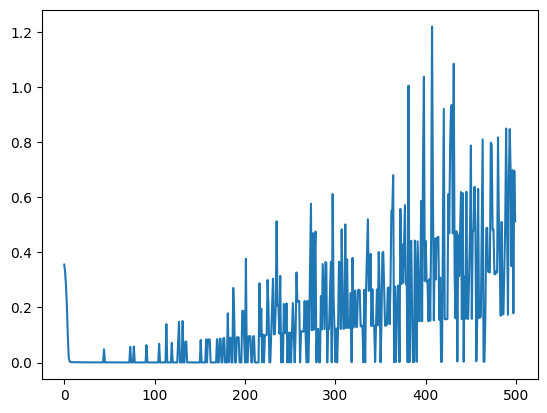

In [68]:
plt.plot(loss_history)

(0.0, 1.0)

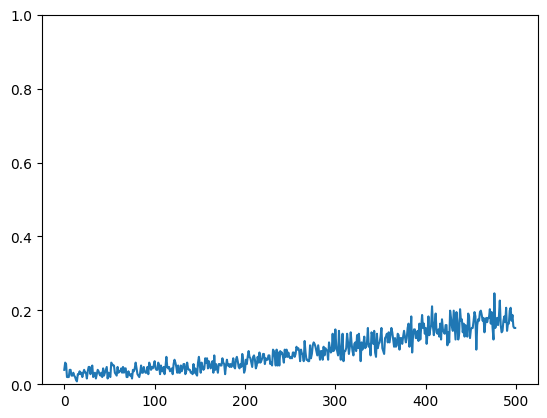

In [69]:
plt.plot(success_history)
plt.ylim(0, 1)

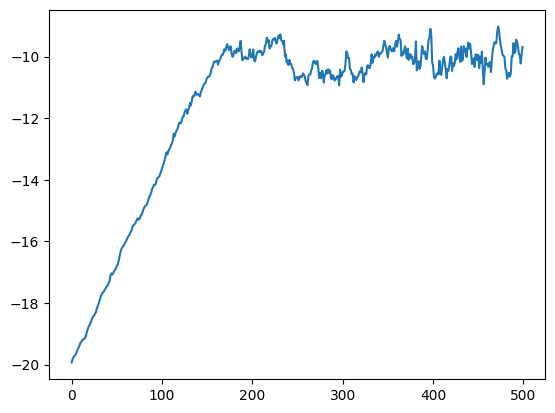

In [70]:
plt.plot(reward_history)